In [182]:
%load_ext autoreload
%autoreload 2
from utils import custom_functions, plot_utils
import os
import sys
sys.path.append("../") # go to parent 
import Bpod_OE_Francesca.utils.load_nested_structs as load_ns
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import math
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0: Os01_Two_Alternative_Choice_20190312_153858.mat,  117 trials on protocol Habituation, stimulation NoStimulation
1: Os01_Two_Alternative_Choice_20190313_164036.mat,  78 trials on protocol Visual, stimulation NoStimulation
2: Os01_Two_Alternative_Choice_20190315_090213.mat,  65 trials on protocol Visual, stimulation NoStimulation
3: Os01_Two_Alternative_Choice_20190318_181923.mat,  127 trials on protocol Visual, stimulation NoStimulation
4: Os01_Two_Alternative_Choice_20190319_173450.mat,  249 trials on protocol Visual, stimulation NoStimulation
5: Os01_Two_Alternative_Choice_20190320_155815.mat,  390 trials on protocol Visual, stimulation NoStimulation
6: Os01_Two_Alternative_Choice_20190321_170938.mat,  317 trials on protocol Visual, stimulation NoStimulation
7: Os01_Two_Alternative_Choice_20190322_131435.mat,  5 trials on protocol Visual, stimulation Right
8: Os01_Two_Alternative_Choice_20190322_134953.mat,  125 trials on protocol Visual, stimulation Right
9: Os01_Two_Alternative_C

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


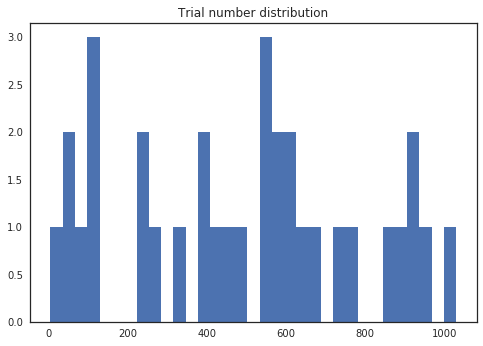

In [266]:
# Make this prettier

# Select animal to analyze
AnimalID = 'Os01'

# Task
BpodProtocol = '/Two_Alternative_Choice/'

# Find data
GeneralDirectory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'

# Create out directory if it does not exist
outputDir = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

ExperimentFiles = [] # to store experiment names
ExperimentData = [] # to store the dictionaries
ntrialsDistribution = [] # to visualize the distribution of the number of trials
Protocols = [] # store the protocols
Stimulations = [] # store the stimulated protocols
counter = 0
for file in glob.glob(GeneralDirectory+AnimalID + BpodProtocol +'Session Data/*.mat'):
    ExperimentFiles.append(file)
    
    # Read data and plot number of trials and training level
    data = load_ns.loadmat(file)
    ntrials = data['SessionData']['nTrials']
    
    # Parse the settings of the trials
    trial_raw_events = data['SessionData']['TrialSettings']
    for trial_num, trial in enumerate(trial_raw_events):
        trial_raw_events[trial_num] = load_ns._todict(trial)
    data['SessionData']['TrialSettings'] = trial_raw_events
    
    # Get info for the settings from the first trial
    try:
        protocol = trial_raw_events[0]['GUIMeta']['TrainingLevel']['String'][
            trial_raw_events[0]['GUI']['TrainingLevel'] - 1]
    except:
        protocol = 'Unknown'
        
    try:
        stimulation = trial_raw_events[0]['GUIMeta']['OptoStim']['String'][
            trial_raw_events[0]['GUI']['OptoStim'] - 1]
    except:
        stimulation = 'unknown'
        
    print('{}: {},  {} trials on protocol {}, stimulation {}'.format(counter ,ntpath.basename(file), ntrials, protocol, stimulation))
    ntrialsDistribution.append(ntrials)
    Protocols.append(protocol)
    Stimulations.append(stimulation)
    
    # as RawEvents.Trial is a cell array of structs in MATLAB, we have to loop through the array and convert the structs to dicts
    trial_raw_events = data['SessionData']['RawEvents']['Trial']
    for trial_num, trial in enumerate(trial_raw_events):
        trial_raw_events[trial_num] = load_ns._todict(trial)
    data['SessionData']['RawEvents']['Trial'] = trial_raw_events

    # Save the data in a list
    ExperimentData.append(data)
    counter+=1

# get the date and time from the files
ExperimentTimes = custom_functions.ParseForTimes(ExperimentFiles)

    
plt.hist(ntrialsDistribution, bins=counter)
plt.title('Trial number distribution')
plt.show()

In [ ]:
# Clean the list


In [183]:
# select a session    
x = 29

In [184]:
# Split data into normal and opto trials
ExpNor, ExpOp = custom_functions.splitOpto(ExperimentData[x]['SessionData'])

In [185]:
# Calculate psychometric performance parameters for each
Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNor['Difficulty'], sideSelected = ExpNor['SideSelected'])
Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOp['Difficulty'], sideSelected = ExpOp['SideSelected'])

In [186]:
# predict data
predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)

if Normal_PsyPer:
    Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
if Opto_PsyPer:
    Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]

In [187]:
# Bootstrap on fake data (generated inside the bootstrap function)
bootstrap_ntimes = 1000
np.random.seed(12233)  # fixed random seed for reproducibility

if Normal_PsyPer:
    Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNor['Difficulty'],
                                                                    sideSelected = ExpNor['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)
if Opto_PsyPer:
    Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOp['Difficulty'],
                                                                    sideSelected = ExpOp['SideSelected'],
                                                                    ntimes = bootstrap_ntimes,
                                                                    prediction_difficulties = predictDif)

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


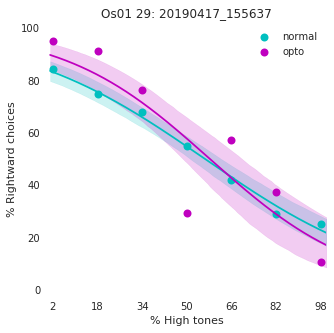

In [188]:
fig, axs = plt.subplots(1,1,figsize=(5, 5), facecolor='w', edgecolor='k')

if Normal_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = Normal_fakePredictions,
                     realPred = Normal_predictPer, color = 'c', label = 'normal')

if Opto_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs, fakePred = Opto_fakePredictions,
                         realPred = Opto_predictPer, color = 'm', label = 'opto')
lgd = plt.legend()
plt.title(AnimalID + ' ' + str(x) + ': ' + ExperimentTimes[x])

plt.savefig(outputDir + AnimalID + '_' + ExperimentTimes[x] + '_psychometricPerformance.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)

In [94]:
# function to compute all of the above:
def ProcessExperiment(SessionData, bootstrap = True):
    # Split data into normal and opto trials
    ExpNor, ExpOp = custom_functions.splitOpto(SessionData=SessionData)
    # Calculate psychometric performance parameters for each
    Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNor['Difficulty'], sideSelected = ExpNor['SideSelected'])
    Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOp['Difficulty'], sideSelected = ExpOp['SideSelected'])
    # predict data
    predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)
    if Normal_PsyPer:
        Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
    else: # needed for the return
        Normal_predictPer = np.nan            
    if Opto_PsyPer:
        Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]
    else: # needed for the return
        Opto_predictPer = np.nan
    # Bootstrap on fake data (generated inside the bootstrap function)
    Normal_fakePredictions = np.nan
    Opto_fakePredictions = np.nan
    if bootstrap:
        bootstrap_ntimes = 1000
        np.random.seed(12233)  # fixed random seed for reproducibility
        if Normal_PsyPer:
            Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNor['Difficulty'],
                                                                            sideSelected = ExpNor['SideSelected'],
                                                                            ntimes = bootstrap_ntimes,
                                                                            prediction_difficulties = predictDif)            
        if Opto_PsyPer:
            Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOp['Difficulty'],
                                                                            sideSelected = ExpOp['SideSelected'],
                                                                            ntimes = bootstrap_ntimes,
                                                                            prediction_difficulties = predictDif)            

    # return what is needed for the plot
    return predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, Opto_PsyPer, \
    Opto_fakePredictions, Opto_predictPer
    

In [178]:
#pull data
SelectedExp = [23,24,29,32]
PulledData = {
    'TrialHighPerc': np.array([y for z in [ExperimentData[x]['SessionData']['TrialHighPerc'] for x in SelectedExp] for y in z]),
    'FirstPoke': np.array([y for z in [ExperimentData[x]['SessionData']['FirstPoke'] for x in SelectedExp] for y in z]),
    'OptoStim': np.array([y for z in [ExperimentData[x]['SessionData']['OptoStim'] for x in SelectedExp] for y in z])
}

predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, \
Opto_PsyPer, Opto_fakePredictions, Opto_predictPer = ProcessExperiment(PulledData)

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


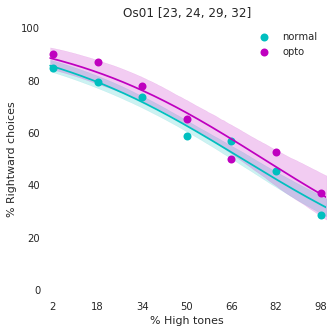

In [179]:
fig, axs = plt.subplots(1,1,figsize=(5, 5), facecolor='w', edgecolor='k')

if Normal_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                     predictDif = predictDif, ax = axs, fakePred = Normal_fakePredictions,
                     realPred = Normal_predictPer, color = 'c', label = 'normal')

if Opto_PsyPer:
    plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs, fakePred = Opto_fakePredictions,
                         realPred = Opto_predictPer, color = 'm', label = 'opto')
lgd = plt.legend()
plt.title(AnimalID + ' ' + str(SelectedExp))

plt.savefig(outputDir + AnimalID + '_' + str(SelectedExp) + '_psychometricPerformance.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)

Progress: [####################] 100.0%


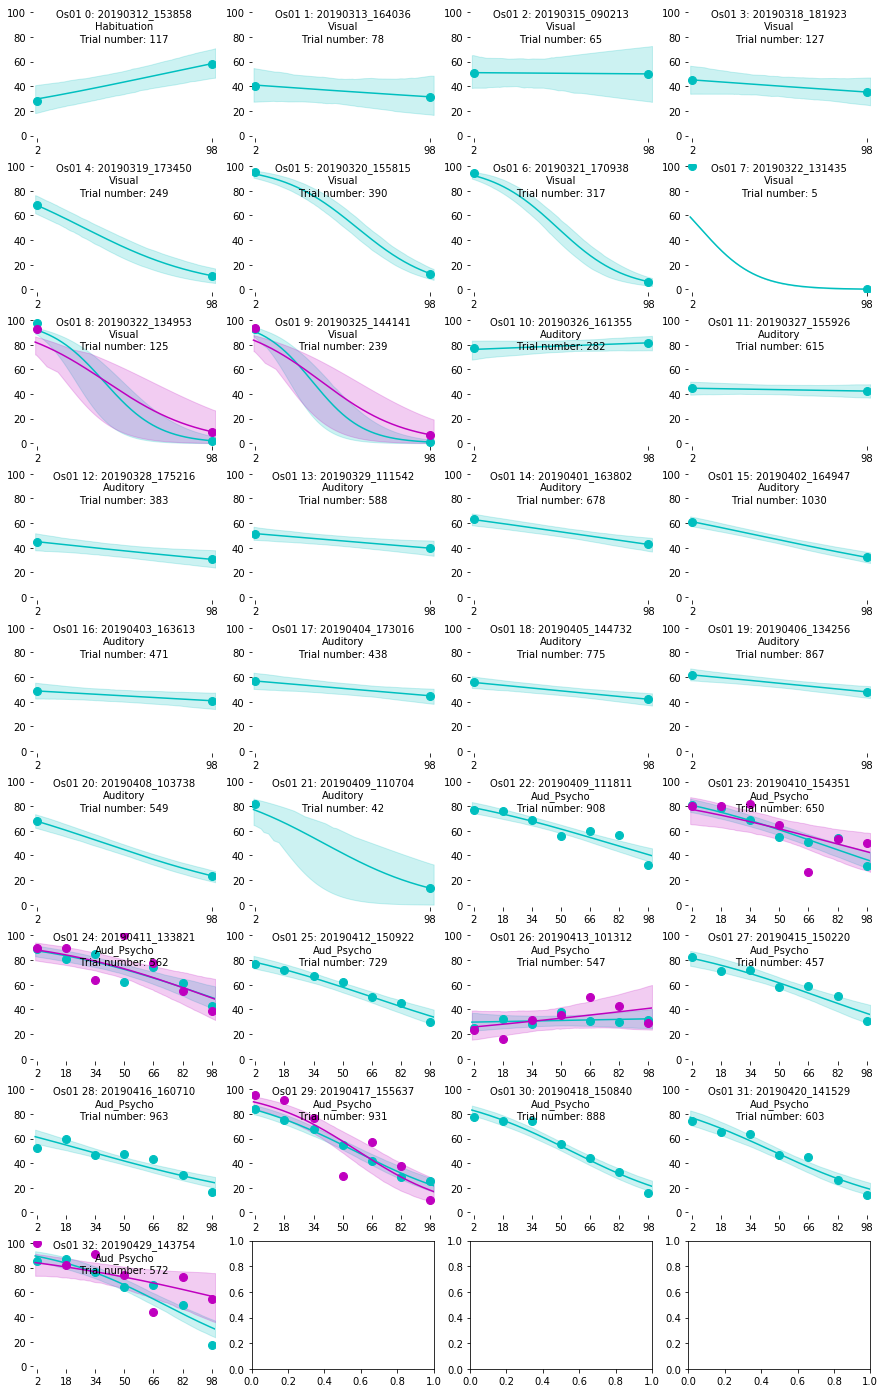

In [97]:
# Make a plot with the performance for all sessions

fig, axs = plt.subplots(math.ceil(len(ExperimentData)/4), 4, figsize=(15, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

for counter, experiment in enumerate(ExperimentData):
    
    predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, \
    Opto_PsyPer, Opto_fakePredictions, Opto_predictPer = ProcessExperiment(experiment['SessionData'])
    
    if Normal_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Normal_PsyPer['Difficulty'], dataPerf = Normal_PsyPer['Performance'],
                         predictDif = predictDif, ax = axs[counter], fakePred = Normal_fakePredictions,
                         realPred = Normal_predictPer, color = 'c', label = 'normal')

    if Opto_PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = Opto_PsyPer['Difficulty'], dataPerf = Opto_PsyPer['Performance'],
                             predictDif = predictDif, ax = axs[counter], fakePred = Opto_fakePredictions,
                             realPred = Opto_predictPer, color = 'm', label = 'opto')
        
    axs[counter].get_legend().remove()
    axs[counter].text(.5,.95, AnimalID + ' ' + str(counter) + ': ' + str(ExperimentTimes[counter]), \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.85, Protocols[counter] , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].text(.5,.75, 'Trial number: ' + str(ntrialsDistribution[counter]) , \
                      horizontalalignment='center', transform=axs[counter].transAxes)
    axs[counter].set_ylabel('')
    axs[counter].set_xlabel('')

    update_progress(counter / len(ExperimentData))
    
update_progress(1)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessions.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show(fig)

In [215]:
# Make one like the IBL

# Initialize lists to save important data
DifficultyValues = []
PerformanceValues = []

# process data from all experiments
for counter, experiment in enumerate(ExperimentData):    
    predictDif, Normal_PsyPer, Normal_fakePredictions, Normal_predictPer, \
    Opto_PsyPer, Opto_fakePredictions, Opto_predictPer = ProcessExperiment(experiment['SessionData'], bootstrap=False)

    #append to lists
    DifficultyValues.append(Normal_PsyPer['Difficulty'])
    PerformanceValues.append(Normal_PsyPer['Performance'])

    update_progress(counter / len(ExperimentData))
    
update_progress(1)


# calculate difficulty levels
difLevels = np.unique(np.concatenate(DifficultyValues).ravel())
# Initialize the matrix
matToPlot = np.full([len(difLevels), len(DifficultyValues)], np.nan)
# Loop to fill it
for i, dif in enumerate(difLevels):
    for j, per in enumerate(PerformanceValues):
        if dif in DifficultyValues[j]:
            idxOfDif = np.where(DifficultyValues[j]==dif)[0][0]
            matToPlot[i,j] = per[idxOfDif]

# Transform to dataframe
dfToPlot = pd.DataFrame(matToPlot)
dfToPlot = dfToPlot.set_index(difLevels) # set row names
dfToPlot.columns = ExperimentTimes # set col names 

Progress: [####################] 100.0%


/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


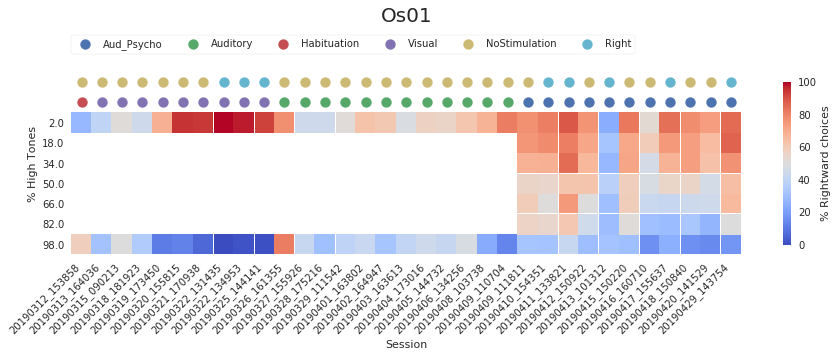

In [296]:
# plot it
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="white")
sns.heatmap(dfToPlot, linewidth=0.001, square=True, cmap="coolwarm",
            cbar_kws={"shrink": 0.6, 'label': '% Rightward choices'})
# label the type of trials
for pr_counter, prot in enumerate(np.unique(Protocols)):
    protIdx = [i for i, x in enumerate(Protocols) if x == prot]
    ax.scatter([x + 0.5 for x in protIdx], np.repeat(len(difLevels)+0.5, len(protIdx)), marker='o', s=100, label = prot)
# label the opto trials
for st_counter, prot in enumerate(np.unique(Stimulations)):
    protIdx = [i for i, x in enumerate(Stimulations) if x == prot]
    ax.scatter([x + 0.5 for x in protIdx], np.repeat(len(difLevels)+1.5, len(protIdx)), marker='o', s=100, label = prot)
ax.legend(loc=(0,1.1), borderaxespad=0., ncol = pr_counter+st_counter+2, frameon=True)
ax.set_ylim([0, len(difLevels)+2])
plt.ylabel('% High Tones')
plt.xlabel('Session')
plt.yticks(rotation=0)
plt.xticks(horizontalalignment="right", rotation=45)
plt.title(AnimalID + '\n\n', fontsize=20, fontweight=0)
plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessionsHeatmap.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)



#plt.show(fig)